In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split


from scipy import optimize
from scipy.io import loadmat

import numba 
from numba import prange

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


d = loadmat('data/macosko.mat')

X_data = d['X_data']
y_data = d['y_data'].reshape(-1)

print(X_data.shape,y_data)

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.33, random_state=42)

X_train = X_data
y_train = y_data

n = X_train.shape[0]

classes = ['Amacrine cells',
           'Astrocytes',
           'Bipolar cells',
           'Cones',
           'Fibroblasts',
           'Horizontal cells',
           'Microglia',
           'Muller glia',
           'Pericytes',
           'Retinal ganglion cells',
           'Rods',
           'Vascular endothelium']
    
print(X_train.shape, y_train.shape, X_train.dtype)
#print(X_test.shape, y_test.shape, X_test.dtype)

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(44808, 50) [ 9.  9.  9. ...  9. 10. 10.]
(44808, 50) (44808,) float32


In [4]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 20000
nB = int((len(X_train_rp) - nA)/2)
nC = nB

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(20000, 50) (12404, 50) (12404, 50)


In [5]:
import numpy as np

import numba
from numba import prange

import random

import scipy.sparse

import gc


@numba.jit(nopython=True, parallel=True)
def euclidean_distances_numba(X, squared = True):
    n = X.shape[0]
    xcorr = np.zeros((n,n),dtype=X.dtype)
    for i in prange(n):
        for j in range(i,n):
            dist = np.sum( np.square(X[i,:] - X[j,:]) )
            if not squared:
                dist = np.sqrt(dist)
            xcorr[i,j] = dist
            xcorr[j,i] = dist
    
    return xcorr

#@numba.jit(nopython=True)
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight

#@numba.jit(nopython=True)
def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    n = prob.shape[0]
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i] #t-conorm
            P[i,j] = p
            P[j,i] = p
            
    return P

def get_prob_matrix(X, n_neighbors=15):
    n = X.shape[0]
    dist = euclidean_distances_numba(X, squared = False)
    sort_idx = np.argsort(dist,axis=1)
    #sort_idx = sort_idx.astype(np.int32)
    sort_idx = sort_idx[:,1:n_neighbors+1]
    
    rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
    rho = np.array(rho)
    
    

    sigmas = []

    directed_graph = []


    #'''
    for i in range(n):
        if (i+1)%1000 == 0:
            print('Processed ', i+1, ' of ', n, ' samples.')
        sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)

        probs = np.zeros(n)
        probs[sort_idx[i,:]] = weights
        #print(sum(weights), np.log2(n_neighbors))
        #print(sort_idx[i,:])
        #print(probs[1770:1780])

        directed_graph.append(probs)

    directed_graph = np.array(directed_graph).astype(np.float32)
    prob = directed_graph
    
    P = symmetrization_step(prob)
    
    graph = scipy.sparse.coo_matrix(P)
    
    return graph

def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights ofhow much we wish to sample each 1-simplex.
    n_epochs: int
        The total number of epochs we want to train for.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    Copied from UMAP repo: https://github.com/lmcinnes/umap/
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    return result
    

In [6]:
graph_1 = get_prob_matrix(data1,n_neighbors=n_neighbors)
print(len(graph_1.data))
graph_1.data[graph_1.data < (graph_1.data.max() / float(epochs))] = 0.0
graph_1.eliminate_zeros()
print(len(graph_1.data))
epochs_per_sample_1_og = make_epochs_per_sample(graph_1.data, epochs)
gc.collect()

graph_2 = get_prob_matrix(data2,n_neighbors=n_neighbors)
print(len(graph_2.data))
graph_2.data[graph_2.data < (graph_2.data.max() / float(epochs))] = 0.0
graph_2.eliminate_zeros()
print(len(graph_2.data))
epochs_per_sample_2_og = make_epochs_per_sample(graph_2.data, epochs)
gc.collect()

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Processed  1000  of  32404  samples.
Processed  2000  of  32404  samples.
Processed  3000  of  32404  samples.
Processed  4000  of  32404  samples.
Processed  5000  of  32404  samples.
Processed  6000  of  32404  samples.
Processed  7000  of  32404  samples.
Processed  8000  of  32404  samples.
Processed  9000  of  32404  samples.
Processed  10000  of  32404  samples.
Processed  11000  of  32404  samples.
Processed  12000  of  32404  samples.
Processed  13000  of  32404  samples.
Processed  14000  of  32404  samples.
Processed  15000  of  32404  samples.
Processed  16000  of  32404  samples.
Processed  17000  of  32404  samples.
Processed  18000  of  32404  samples.
Processed  19000  of  32404  samples.
Processed  20000  of  32404  samples.
Processed  21000  of  32404  samples.
Processed  22000  of  32404  samples.
Processed  23000  of  32404  samples.
Processed  24000  of  32404  samples.
Processed  25000  of  32404  samples.
Processed  26000  of  32404  samples.
Processed  27000  of 

0

In [7]:
print(epochs_per_sample_1_og.data.shape, epochs_per_sample_2_og.data.shape)

(1611650,) (1609028,)


Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


<IPython.core.display.Javascript object>


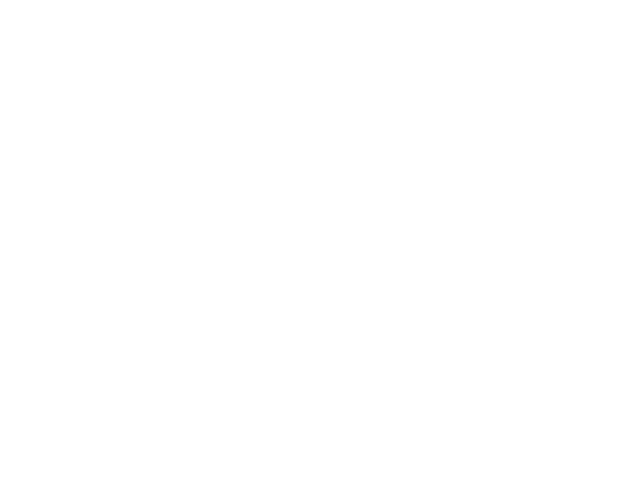

In [8]:
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [9]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
embB = np.random.randn(SETB.shape[0],n_components).astype(np.float32)
embC = np.random.randn(SETC.shape[0],n_components).astype(np.float32)

neg_sample_rate = 5
repulsion_strength=1.0

print(embB.shape)

(12404, 2)


In [10]:
@numba.jit(nopython=True)
def clip(x,val=4.0):

    if x>val:
        return val
    elif x<-val:
        return -val
    else:
        return x
    
@numba.jit(nopython=True)
def update_attraction(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2*a*b*dist**(b-1.0) / (1 + a * dist**b)
    else:
        grad_coeff = 0.0


    for d in range(dim):
        mv = clip(grad_coeff * P * (x[0,d]-y[0,d]))  # * P[idx,idy]
        mv = mv * lr

        x[0,d] -= mv
        y[0,d] += mv
        
    return

@numba.jit(nopython=True)
def update_repulsion(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2 * repulsion_strength * b / ( (0.001+dist) * (1.0 + a * dist**b) )
    else:
        grad_coeff = 0


    for d in range(dim):
        #if grad_coeff > 0.0:
        #    grad = clip(grad_coeff  * (x[0,d]-y[0,d]))
        #    #* (1 - P[idx,idy])
        #else:
        #    grad = 0.0

        grad = clip(grad_coeff  * (x[0,d]-y[0,d]) * (1-P))
        mv = grad * lr

        x[0,d] += mv
        #y[0,d] -= mv

    
    return

@numba.jit(nopython=True)
def one_step_in_a_set(emA, emH, idx, rows, columns, a, b, dim,
                   nA, n_points,
                   epochs_per_sample,
                   epoch_of_next_sample,
                   epochs_per_negative_sample,
                   epoch_of_next_negative_sample,
                   lr, epoch):
    
    if epoch_of_next_sample[idx] <= epoch:
        x_idx = rows[idx]
        y_idx = columns[idx]
        
        if x_idx < nA:
            x = emA[x_idx:x_idx+1,:]
        else:
            x = emH[x_idx-nA:x_idx-nA+1,:]
        
        if y_idx < nA:
            y = emA[y_idx:y_idx+1, :]
        else:
            y = emH[y_idx-nA:y_idx-nA+1,:]
            
        update_attraction(x, y, a, b, dim, lr, 1)
        
        epoch_of_next_sample[idx] += epochs_per_sample[idx]
        
        n_neg_samples = int(
                (epoch - epoch_of_next_negative_sample[idx]) / epochs_per_negative_sample[idx]
            )
        
        for i in range(n_neg_samples):
            y_idx = np.random.choice(n_points)
            
            if x_idx == y_idx:
                continue
            
            if y_idx < nA:
                y = emA[y_idx:y_idx+1, :]
            else:
                y = emH[y_idx-nA:y_idx-nA+1,:]
                
            update_repulsion(x, y, a, b, dim, lr, 0)
            
        epoch_of_next_negative_sample[idx] += (
                n_neg_samples * epochs_per_negative_sample[idx]
            )
            
            
            
    
    return 

@numba.jit(nopython=True,parallel=True)
def one_epoch_2sets_2(emCommon, em1, em2,
                     rows1, columns1, rows2, columns2,
                     nCommon, n_points_1, n_points_2,
                      Set, K_idx,
                     a, b, dim,
                     lr, epoch,
                     epochs_per_sample_1,
                     epoch_of_next_sample_1,
                     epochs_per_negative_sample_1,
                     epoch_of_next_negative_sample_1,
                     epochs_per_sample_2,
                     epoch_of_next_sample_2,
                     epochs_per_negative_sample_2,
                     epoch_of_next_negative_sample_2,
                     repulsion_strength=1.0):
    '''
    Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
    Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
    Set = np.random.permutation(np.concatenate((Set1,Set2)))
    '''
    
    for i in prange(len(Set)):
        if Set[i] == 1:
            one_step_in_a_set(emA=emCommon, emH=em1, idx=K_idx[i], 
                              rows=rows1, columns=columns1, a=a, b=b, dim=dim,
                              nA=nCommon, n_points=n_points_1,
                              epochs_per_sample=epochs_per_sample_1,
                              epoch_of_next_sample=epoch_of_next_sample_1,
                              epochs_per_negative_sample=epochs_per_negative_sample_1,
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample_1,
                              lr=lr, epoch=epoch)
        elif Set[i] == 2:
            one_step_in_a_set(emA=emCommon, emH=em2, idx=K_idx[i], 
                              rows=rows2, columns=columns2, a=a, b=b, dim=dim,
                              nA=nCommon, n_points=n_points_2,
                              epochs_per_sample=epochs_per_sample_2,
                              epoch_of_next_sample=epoch_of_next_sample_2,
                              epochs_per_negative_sample=epochs_per_negative_sample_2,
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample_2,
                              lr=lr, epoch=epoch)
        else:
            print('Warning: Something Wrong')
    
    
    return 

from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)
embB = pca.transform(SETB) #np.random.randn(SETB.shape[0],n_components).astype(np.float32)
embB = (embB * expansion).astype(np.float32)
embC = pca.transform(SETC) #np.random.randn(SETC.shape[0],n_components).astype(np.float32)
embC = (embC * expansion).astype(np.float32)

neg_sample_rate = 5
repulsion_strength=1.0


epochs_per_sample_1 = epochs_per_sample_1_og.copy()
epoch_of_next_sample_1 = epochs_per_sample_1.copy()
epochs_per_negative_sample_1 = epochs_per_sample_1 / neg_sample_rate
epoch_of_next_negative_sample_1 = epochs_per_negative_sample_1.copy()

epochs_per_sample_2 = epochs_per_sample_1_og.copy()
epoch_of_next_sample_2 = epochs_per_sample_2.copy()
epochs_per_negative_sample_2 = epochs_per_sample_2 / neg_sample_rate
epoch_of_next_negative_sample_2 = epochs_per_negative_sample_2.copy()


print(embB.shape)
init_lr = 1.0

Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
Set = np.random.permutation(np.concatenate((Set1,Set2)))
k_idx_1 = np.arange(epochs_per_sample_1.shape[0],dtype=np.int)
k_idx_2 = np.arange(epochs_per_sample_2.shape[0],dtype=np.int)
K_idx = np.zeros(Set.shape[0],dtype=np.int)
K_idx[Set==1] = k_idx_1
K_idx[Set==2] = k_idx_2

import timeit

for epoch in range(epochs):
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    one_epoch_2sets_2(emCommon=embA, em1=embB, em2=embC, 
                     rows1=graph_1.row, columns1=graph_1.col, 
                     rows2=graph_2.row, columns2=graph_2.col, 
                     nCommon=len(embA), 
                     n_points_1=len(embA)+len(embB), n_points_2=len(embA)+len(embC),
                     Set = Set, K_idx=K_idx,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample_1=epochs_per_sample_1,
                     epoch_of_next_sample_1=epoch_of_next_sample_1,
                     epochs_per_negative_sample_1=epochs_per_negative_sample_1,
                     epoch_of_next_negative_sample_1=epoch_of_next_negative_sample_1,
                     epochs_per_sample_2=epochs_per_sample_2,
                     epoch_of_next_sample_2=epoch_of_next_sample_2,
                     epochs_per_negative_sample_2=epochs_per_negative_sample_2,
                     epoch_of_next_negative_sample_2=epoch_of_next_negative_sample_2,
                     repulsion_strength=repulsion_strength)
    
    stop = timeit.default_timer()
    #print('Time for epoch ', epoch, ': ', stop - start) 
    

(12404, 2)
epoch  0 of  200
epoch  20 of  200
epoch  40 of  200
epoch  60 of  200
epoch  80 of  200
epoch  100 of  200
epoch  120 of  200
epoch  140 of  200
epoch  160 of  200
epoch  180 of  200


<IPython.core.display.Javascript object>


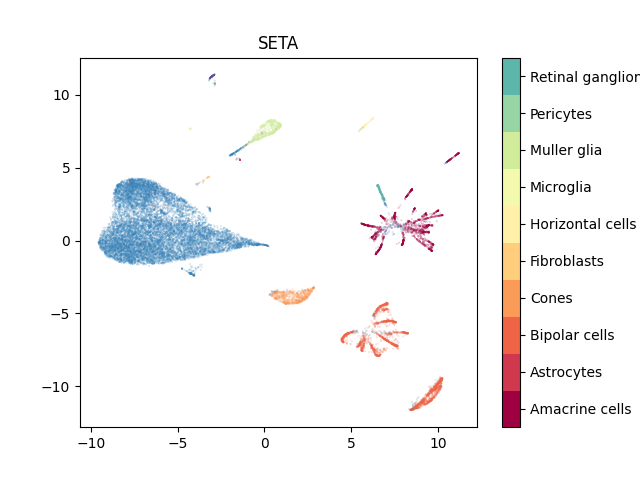

(20000, 2)


<IPython.core.display.Javascript object>


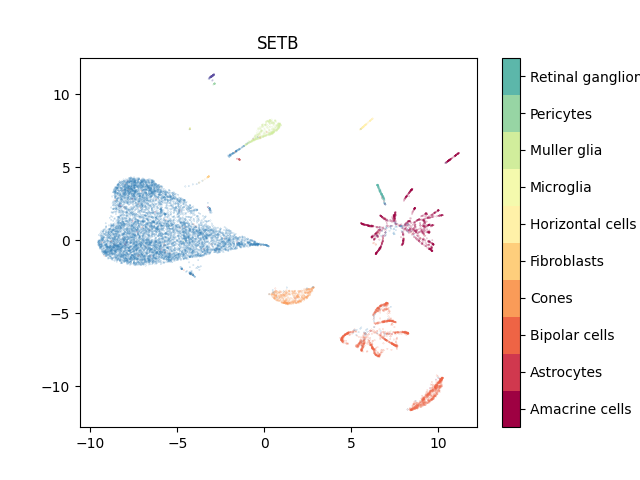

(12404, 2)


<IPython.core.display.Javascript object>


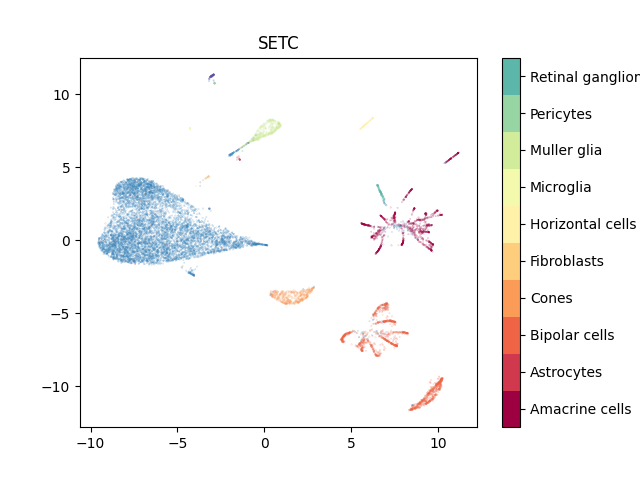

(12404, 2)


In [11]:
%matplotlib notebook

plt.figure()
plt.title('SETA')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plt.figure()
plt.title('SETB')
print(embB.shape)
plt.scatter(embB[:,0], embB[:,1], c=y_SETB, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plt.figure()
plt.title('SETC')
print(embC.shape)
plt.scatter(embC[:,0], embC[:,1], c=y_SETC, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)



In [12]:
with open('MACOSKO_Aligned_NE_20K.npy', 'wb') as f:
    np.save(f, embA)
    np.save(f, embB)
    np.save(f, embC)